# Test EFAS6: Ebro
***

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# from lisflood_read_plot import *

In [ ]:
from lisfloodreservoirs import read_timeseries
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.calibration.camaflood_calibrator import CamafloodCalibrator
from lisfloodreservoirs.models import get_model
from lisfloodreservoirs.models import Camaflood
from lisfloodreservoirs.utils.metrics import KGEmod
from lisfloodreservoirs.utils.utils import return_period

In [4]:
import spotpy

In [5]:
import yaml

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Configuration

In [7]:
path_efas = Path('Z:/nahaUsers/casadje/EFASv6/reservoirs/')

In [8]:
path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

## Data
### Reservoirs

In [39]:
# import reservoirs
reservoirs = gpd.read_file(
    path_efas / 'tables' / 'reservoirs_efas6_20250303.shp'
).set_index('GDW_ID')
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype('Int64')

# add calibrated/estimated parameters
for parname in ['flood_storage', 'outflow_factor']:
    series = pd.read_csv(
        path_efas / 'tables' / 'parameters' / f'reservoirs_efas6_{parname}.txt', 
        header=None,
        index_col=0,
        sep='\t'
    ).squeeze()
    series.index.name = 'GDW_ID',
    series.name = parname
    reservoirs = pd.concat((reservoirs, series), axis=1)

print(f'{len(reservoirs)} reservoirs in total')

# keep only reservoirs in the Ebro
grand_ids = pd.read_csv(path_resops / 'selection' / 'ebro_all.txt', header=None).squeeze().tolist()
reservoirs = reservoirs[reservoirs.GRAND_ID.isin(grand_ids)]
reservoirs.sort_index(inplace=True)

print(f'{len(reservoirs)} reservoirs in the Ebro')

1545 reservoirs in total
37 reservoirs in the Ebro


### Time series

#### LISFLOOD simulation

In [40]:
path_sim = path_efas / 'tests' / 'Ebro'

# read_simulated time series
timeseries = {}
files = {
    'storage': path_sim / 'RES_fill.csv',
    'inflow': path_sim / 'RES_inflow.csv',
    'outflow': path_sim / 'RES_outflow.csv'
}

for var, file in files.items():
    df = pd.read_csv(file, parse_dates=True, index_col='Timestamp')
    df.index = pd.to_datetime(df.index, format="%d/%m/%Y %H:%M")
    df.columns = df.columns.astype(int)
    gdw_ids = df.columns.intersection(reservoirs.index)
    timeseries[var] = df[gdw_ids]
gdw_ids.sort()

# reorganize by ID
Sim_lisflood = {}
for gdw_id in gdw_ids:
    serie_list = []
    for var, df in timeseries.items():
        serie = df[gdw_id]
        serie.name = var
        if var == 'storage':
            cap_cm = reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
            serie *= cap_cm
        serie_list.append(serie)
    Sim_lisflood[gdw_id] = pd.concat(serie_list, axis=1)

# clip reservoirs to those simulated
reservoirs = reservoirs.loc[Sim_lisflood.keys()]

print(f'{len(reservoirs)} reservoirs with simulated time series')

28 reservoirs


### Observed

In [42]:
# read observed time series
Obs = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=reservoirs.loc[Sim_lisflood.keys(), 'GRAND_ID'].dropna().astype(int).tolist(),
    variables=['inflow', 'outflow', 'storage']
)
# convert GRAND_ID to GDW_ID 
Obs = {reservoirs.loc[reservoirs.GRAND_ID == grand_id].index.item(): ts for grand_id, ts in Obs.items()}
# # convert storage to filling
# for gdw_id, ts in obs.items():
#     ts['storage'] /= reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6

print(f'{len(Obs)} reservoirs with observed time series')

  0%|          | 0/28 [00:00<?, ?it/s]

File Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series\csv\3474.csv doesn't exist
File Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series\csv\3500.csv doesn't exist
File Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series\csv\2757.csv doesn't exist
File Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series\csv\2729.csv doesn't exist
24 reservoirs with observed time series


## Analysis

In [43]:
path_plots = path_sim / 'plots'
path_plots.mkdir(exist_ok=True)

### LISFLOOD calibration

In [44]:
variables = ['inflow', 'storage', 'outflow']
lisflood_performance = pd.DataFrame(index=gdw_ids, columns=[f'KGE_{var}' for var in variables])
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Vmin = 0.5 * Vf
    Qf = Q100 * par_Qf
    Qmin = 0.5 * Qn

    # reservoir limits
    Vlims = [Vmin, Vf, Ve, cap_cm]
    Qlims = [Qmin, Qf, Qf, Qf]

    # declare reservoir
    res = Camaflood(
        Vmin=Vmin,
        Vf=Vf,
        Ve=Ve,
        Vtot=cap_cm,
        Qn=Qn,
        Qf=Qf,
        catchment=catch_sm,
        Atot=area_sm,
        # timestep=6*3600
    )

    # time series
    if gdw_id in Obs:
        obs = Obs[gdw_id]
    else:
        continue
    sim = Sim_lisflood[gdw_id]
    
    # compare LISFLOOD vs observation
    res.scatter(
        sim,
        obs,
        norm=False,
        title=gdw_id,
        Vlims=Vlims,
        Qlims=Qlims,
        labels=['Lisflood', 'observed'],
        save=path_plots / f'{gdw_id}_scatter_lisflood_vs_observed.jpg'
    )

    for var in variables:
        lisflood_performance.loc[gdw_id, f'KGE_{var}'] = KGEmod(obs[var], sim[var])[0]

reservoirs:   0%|          | 0/28 [00:00<?, ?it/s]

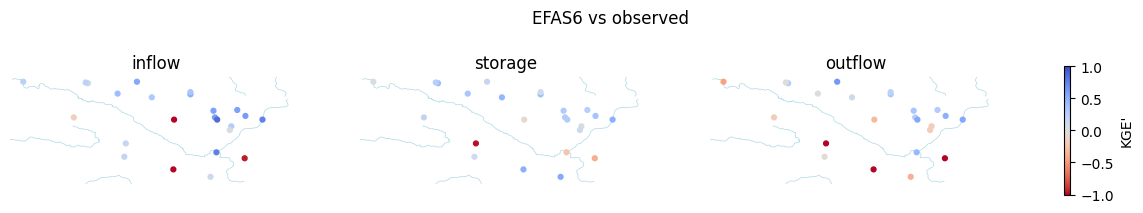

In [45]:
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(ncols=3, figsize=(16, 2.5), subplot_kw={"projection": projection})
for ax, var in zip(axes, variables):
    col = f'KGE_{var}'
    sct = ax.scatter(
        reservoirs.geometry.x,
        reservoirs.geometry.y,
        c=lisflood_performance[col],
        cmap='coolwarm_r',
        s=12,
        vmin=-1, 
        vmax=1
    )
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='lightblue', linewidth=0.5, zorder=0)
    ax.set_title(var)
    ax.axis('off')
fig.colorbar(sct, ax=axes, label="KGE'", shrink=.666)
fig.suptitle('EFAS6 vs observed');

### CaMa-Flood simulation

Simulation of the CaMa-Flood routine with the inflow simulated with the new GloFAS setup.

In [46]:
Sim_camaflood = {}
camaflood_performance = pd.DataFrame(index=gdw_ids, columns=[f'KGE_{var}' for var in variables])
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Vmin = 0.5 * Vf
    Qf = Q100 * par_Qf
    Qmin = 0.5 * Qn

    # reservoir limits
    Vlims = [Vmin, Vf, Ve, cap_cm]
    Qlims = [Qmin, Qf, Qf, Qf]

    # declare reservoir
    res = Camaflood(
        Vmin=Vmin,
        Vf=Vf,
        Ve=Ve,
        Vtot=cap_cm,
        Qn=Qn,
        Qf=Qf,
        catchment=catch_sm,
        Atot=area_sm,
        timestep=6*3600
    )

    # time series
    obs = Obs[gdw_id] if gdw_id in Obs else None
    sim_lf = Sim_lisflood[gdw_id]
    
    # simulate with Lisflood inflow
    sim_cf = res.simulate(sim_lf.inflow)
    # ts.storage /= cap_cm
    Sim_camaflood[gdw_id] = sim_cf

    # compare LISFLOOD vs observation
    if obs is not None:
        res.scatter(
            sim_lf,
            sim_cf,
            norm=False,
            title=gdw_id,
            Vlims=Vlims,
            Qlims=Qlims,
            labels=['Lisflood', 'CaMa-Flood'],
            save=path_plots / f'{gdw_id}_scatter_lisflood_vs_camaflood.jpg'
        )
    res.lineplot(
        sim={
            'Lisflood': sim_lf.groupby(sim_lf.index.floor('D')).mean(),
            'CaMa-Flood': sim_cf.groupby(sim_cf.index.floor('D')).mean()
        },
        obs=obs,
        Vlims=Vlims,
        Qlims=Qlims,
        # spinup=cfg.SPINUP,
        title=gdw_id,
        figsize=(12, 6),
        save=path_plots / f'{gdw_id}_line_simulated_vs_observed.jpg'
    )

    if obs is not None:
        for var in variables:
            camaflood_performance.loc[gdw_id, f'KGE_{var}'] = KGEmod(obs[var], sim_cf[var])[0]

reservoirs:   0%|          | 0/28 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

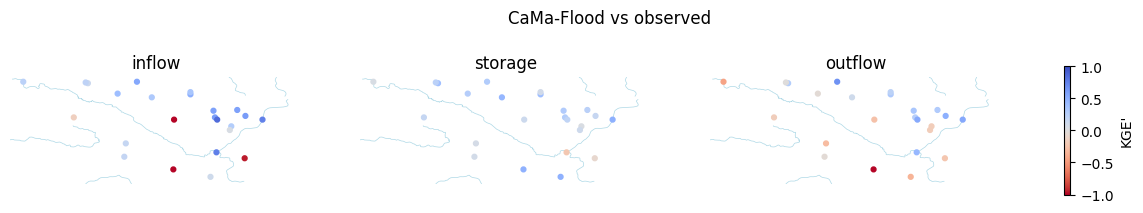

In [47]:
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(ncols=3, figsize=(16, 2.5), subplot_kw={"projection": projection})
for ax, var in zip(axes, variables):
    col = f'KGE_{var}'
    sct = ax.scatter(
        reservoirs.geometry.x,
        reservoirs.geometry.y,
        c=camaflood_performance[col],
        cmap='coolwarm_r',
        s=12,
        vmin=-1, 
        vmax=1
    )
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='lightblue', linewidth=0.5, zorder=0)
    ax.set_title(var)
    ax.axis('off')
fig.colorbar(sct, ax=axes, label="KGE'", shrink=.666)
fig.suptitle('CaMa-Flood vs observed');

### CaMa-Flood calibration

In [51]:
parameters = {
    'alpha': {
        'low': 0.2,
        'high': 0.99
    },
    'delta': {
        'low': 0.1,
        'high': 0.5
    },
}

target = ['storage', 'outflow']

In [62]:
path_calib = path_sim / 'camaflood'
path_calib.mkdir(exist_ok=True)

# sim_camaflood = {}
for gdw_id in tqdm(gdw_ids, desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Vmin = 0.5 * Vf
    Qf = Q100 * par_Qf
    Qmin = 0.5 * Qn

    # reservoir limits
    Vlims = [Vmin, Vf, Ve, cap_cm]
    Qlims = [Qmin, Qf, Qf, Qf]

    # time series
    obs = Obs[gdw_id] if gdw_id in Obs else None
    available = obs[target].notnull().all(axis=1)
    start, end = available[available].first_valid_index(), available[available].last_valid_index()
    sim_lf = Sim_lisflood[gdw_id]
    sim_lf = sim_lf.groupby(sim_cf.index.floor('D')).mean()
    
    # declare reservoir
    calibrator = CamafloodCalibrator(
        parameters=parameters,
        inflow=sim_lf.loc[start:end, 'inflow'],
        storage=obs.loc[start:end, 'storage'],
        outflow=obs.loc[start:end, 'outflow'],
        Vmin=max(0, min(0.1 * cap_cm, obs.storage.min())),
        Vtot=cap_cm,
        catchment=catch_sm,
        # Atot=area_sm,
        target=['storage', 'outflow'],
        obj_func=KGEmod,
        spinup=None,
    )

    # define the sampling method
    dbname = f'{path_calib}/{gdw_id}_samples'
    sceua = spotpy.algorithms.sceua(
        calibrator, 
        dbname=dbname, 
        dbformat='csv', 
        save_sim=False,
    )

    # launch calibration
    sceua.sample(
        5000, 
        ngs=4, 
        kstop=5, 
        pcento=0.001, 
        peps=0.01
    )

reservoirs:   0%|          | 0/28 [00:00<?, ?it/s]

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  5000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\EFASv6\reservoirs\tests\Ebro\camaflood/3974_samples.csv' created.


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

5 of 5000, minimal objective function=1.12217, time remaining: 00:29:41


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

11 of 5000, minimal objective function=1.10614, time remaining: 00:30:39


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

17 of 5000, minimal objective function=1.10614, time remaining: 00:31:07


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

29 of 5000, minimal objective function=1.10614, time remaining: 00:30:07


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

43 of 5000, minimal objective function=1.10614, time remaining: 00:27:14


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

55 of 5000, minimal objective function=1.10513, time remaining: 00:25:12


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

69 of 5000, minimal objective function=1.10513, time remaining: 00:24:10
ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

81 of 5000, minimal objective function=1.10496, time remaining: 00:23:14


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

96 of 5000, minimal objective function=1.10496, time remaining: 00:23:01


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

108 of 5000, minimal objective function=1.10496, time remaining: 00:22:28


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

122 of 5000, minimal objective function=1.10475, time remaining: 00:22:05
ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

135 of 5000, minimal objective function=1.10426, time remaining: 00:21:52


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

149 of 5000, minimal objective function=1.10426, time remaining: 00:21:36


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

162 of 5000, minimal objective function=1.10426, time remaining: 00:21:18


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

175 of 5000, minimal objective function=1.10426, time remaining: 00:21:03
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

190 of 5000, minimal objective function=1.10357, time remaining: 00:21:01


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

206 of 5000, minimal objective function=1.10357, time remaining: 00:21:01


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

218 of 5000, minimal objective function=1.10327, time remaining: 00:20:52


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

230 of 5000, minimal objective function=1.10327, time remaining: 00:20:43
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

245 of 5000, minimal objective function=1.10327, time remaining: 00:20:38


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

259 of 5000, minimal objective function=1.10327, time remaining: 00:20:31


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

273 of 5000, minimal objective function=1.10327, time remaining: 00:20:27


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

288 of 5000, minimal objective function=1.10327, time remaining: 00:20:22
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.168149
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

300 of 5000, minimal objective function=1.10327, time remaining: 00:20:11


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

315 of 5000, minimal objective function=1.10327, time remaining: 00:20:07


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

328 of 5000, minimal objective function=1.10327, time remaining: 00:20:03


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

343 of 5000, minimal objective function=1.10327, time remaining: 00:19:59
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.134061
ComplexEvo loop #7 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

356 of 5000, minimal objective function=1.10327, time remaining: 00:19:51


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

369 of 5000, minimal objective function=1.10327, time remaining: 00:19:44


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

384 of 5000, minimal objective function=1.10327, time remaining: 00:19:42


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

398 of 5000, minimal objective function=1.10327, time remaining: 00:19:37
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.089432
ComplexEvo loop #8 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

412 of 5000, minimal objective function=1.10327, time remaining: 00:19:31


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

428 of 5000, minimal objective function=1.10327, time remaining: 00:19:32


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

442 of 5000, minimal objective function=1.10327, time remaining: 00:19:27


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

457 of 5000, minimal objective function=1.10327, time remaining: 00:19:23
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000000
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.001000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 461
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.734941
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY 0.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 117.29 seconds
Total Repetitions: 461
Minimal objective value: 1.10327
Corresponding parameter setting:
alpha: 0.41201
delta: 0.302977
******************************

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  5000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\EFASv6\reservoirs\tests\Ebro\camaflood/6006_samples.csv' created.


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

5 of 5000, minimal objective function=1.36221, time remaining: 00:28:22


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

11 of 5000, minimal objective function=1.36221, time remaining: 00:29:33


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

17 of 5000, minimal objective function=1.36221, time remaining: 00:29:51


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

28 of 5000, minimal objective function=1.36221, time remaining: 00:29:10


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

41 of 5000, minimal objective function=1.36221, time remaining: 00:26:21


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

53 of 5000, minimal objective function=1.36221, time remaining: 00:24:24


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

65 of 5000, minimal objective function=1.36208, time remaining: 00:23:12
ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

80 of 5000, minimal objective function=1.36208, time remaining: 00:22:37


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

95 of 5000, minimal objective function=1.36208, time remaining: 00:22:22


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

109 of 5000, minimal objective function=1.36208, time remaining: 00:21:58


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

121 of 5000, minimal objective function=1.36208, time remaining: 00:21:29
ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

134 of 5000, minimal objective function=1.36208, time remaining: 00:21:10


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

148 of 5000, minimal objective function=1.36208, time remaining: 00:21:05


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

160 of 5000, minimal objective function=1.36208, time remaining: 00:20:47


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

174 of 5000, minimal objective function=1.36208, time remaining: 00:20:36
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

187 of 5000, minimal objective function=1.36208, time remaining: 00:20:23


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

201 of 5000, minimal objective function=1.35587, time remaining: 00:20:19


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

215 of 5000, minimal objective function=1.34418, time remaining: 00:20:10


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

228 of 5000, minimal objective function=1.34418, time remaining: 00:20:00
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

242 of 5000, minimal objective function=1.32483, time remaining: 00:19:59


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

256 of 5000, minimal objective function=1.32483, time remaining: 00:19:53


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

270 of 5000, minimal objective function=1.32483, time remaining: 00:19:47


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

282 of 5000, minimal objective function=1.31443, time remaining: 00:19:37
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 3.532431
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

297 of 5000, minimal objective function=1.31443, time remaining: 00:19:36


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

312 of 5000, minimal objective function=1.31443, time remaining: 00:19:31


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

327 of 5000, minimal objective function=1.31443, time remaining: 00:19:27


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

341 of 5000, minimal objective function=1.31443, time remaining: 00:19:25
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 3.557565
ComplexEvo loop #7 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

355 of 5000, minimal objective function=1.31443, time remaining: 00:19:19


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

368 of 5000, minimal objective function=1.31443, time remaining: 00:19:13


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

381 of 5000, minimal objective function=1.31443, time remaining: 00:19:06


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

394 of 5000, minimal objective function=1.31443, time remaining: 00:19:03
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 3.583059
ComplexEvo loop #8 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

409 of 5000, minimal objective function=1.31443, time remaining: 00:18:59


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

424 of 5000, minimal objective function=1.31443, time remaining: 00:18:55


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

438 of 5000, minimal objective function=1.31443, time remaining: 00:18:53


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

452 of 5000, minimal objective function=1.31443, time remaining: 00:18:50
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 2.253133
ComplexEvo loop #9 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

467 of 5000, minimal objective function=1.31443, time remaining: 00:18:46


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

481 of 5000, minimal objective function=1.3137, time remaining: 00:18:41


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

494 of 5000, minimal objective function=1.3137, time remaining: 00:18:38


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

507 of 5000, minimal objective function=1.3137, time remaining: 00:18:32
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.055593
ComplexEvo loop #10 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

522 of 5000, minimal objective function=1.3137, time remaining: 00:18:28


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

536 of 5000, minimal objective function=1.3137, time remaining: 00:18:24


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

550 of 5000, minimal objective function=1.31319, time remaining: 00:18:22


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

565 of 5000, minimal objective function=1.31319, time remaining: 00:18:18
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.094017
ComplexEvo loop #11 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

580 of 5000, minimal objective function=1.31319, time remaining: 00:18:15


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

595 of 5000, minimal objective function=1.31319, time remaining: 00:18:13


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

609 of 5000, minimal objective function=1.31318, time remaining: 00:18:09


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

623 of 5000, minimal objective function=1.31318, time remaining: 00:18:05
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.094761
ComplexEvo loop #12 in progress...


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

638 of 5000, minimal objective function=1.31318, time remaining: 00:18:03


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

653 of 5000, minimal objective function=1.31318, time remaining: 00:17:59


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

667 of 5000, minimal objective function=1.31318, time remaining: 00:17:55


timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

timesteps:   0%|          | 0/11231 [00:00<?, ?it/s]

681 of 5000, minimal objective function=1.31318, time remaining: 00:17:50
THE POPULATION HAS CONVERGED TO A PRESPECIFIED SMALL PARAMETER SPACE
SEARCH WAS STOPPED AT TRIAL NUMBER: 685
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.007554
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY 0.094761 PERCENT

*** Final SPOTPY summary ***
Total Duration: 169.12 seconds
Total Repetitions: 685
Minimal objective value: 1.31318
Corresponding parameter setting:
alpha: 0.98999
delta: 0.100088
******************************



TypeError: 'NoneType' object is not subscriptable

In [ ]:
gdw_id = 1407

In [ ]:
# read calibration results
dbname = f'{path_calib}/{gdw_id}_samples'
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
reservoir = get_model('camaflood', **calibrated_attrs)

In [ ]:
calibrated_attrs

In [ ]:
# export calibrated parameters
with open(path_calib / f'{gdw_id}_optimal_parameters.yml', 'w') as file:
    yaml.dump(reservoir.get_params(), file)

In [ ]:
# simulate the reservoir
Vo = obs[gdw_id].loc[start, 'storage'] #ts.storage.iloc[0]
sim = reservoir.simulate(
    inflow=sim_lisflood[gdw_id].loc[start:end, 'inflow'],
    Vo=None if pd.isna(Vo) else Vo,
)
# sim_cal.to_csv(cfg.PATH_CALIB / f'{grand_id}_simulation.csv', float_format='%.3f')

In [ ]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
print(f'{gdw_id}\tk = {k:.3f}')

# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Qf = Q100 * par_Qf

year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)

flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)

for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
    ax.scatter(
        sim[flood_mode].index, 
        sim.loc[flood_mode, var], 
        marker='.', 
        s=.8, 
        color='firebrick')
    ax.scatter(
        sim[~flood_mode].index, 
        sim.loc[~flood_mode, var], 
        marker='.', 
        s=.8, 
        color='steelblue'
    )
    if var in ['storage', 'outflow']:
        ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
    ax.set_ylabel(var)
    
for y in [0.5 * Vf, Vf, Ve, cap_cm]:
    axes[0].axhline(y, ls='--', c='k', lw=.5)
start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
ax.set_xlim(start, end)

for y in [0.5 * Qn, Qf]:
    axes[1].axhline(y, ls='--', c='k', lw=.5)
    axes[2].axhline(y, ls='--', c='k', lw=.5)

axes[0].set_title(f'{gdw_id} | k = {k:.3f}');

# plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

In [ ]:
(1 - results.like1).plot()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
sct = ax.scatter(
    x=results.alpha, 
    y=results.delta, 
    c=(1 - results.like1), 
    s=8,
    cmap='coolwarm_r', 
    alpha=.5,
    # vmin=-1, 
    # vmax=1
)
ax.set(
    xlabel='flood storage',
    ylabel='flood outflow',
    title=gdw_id,
)
plt.colorbar(sct, shrink=.5, label="KGE'");

***

In [ ]:
for gdw_id, sim in tqdm(sim_lisflood.items(), desc='reservoirs'):

    # extract reservoir characteristics
    cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
    # extract inflow characteristics
    Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
    # extract reservoir parameters
    par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_stor', 'outflow_fa']]

    k = max(1 - 5 * (cap_cm - Vf) / catch_sm, 0)
    print(f'{gdw_id}\tk = {k:.3f}')

    # define reservoir limits
    Vf = par_Vf * cap_cm
    Ve = cap_cm * (0.8 + 0.2 * par_Vf)
    Qf = Q100 * par_Qf

    year_start, year_end = reservoirs.loc[gdw_id, ['YEAR_DAM', 'REM_YEAR']]

    
    fig, axes = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
    
    flood_mode = (sim.storage > Vf) & (sim.inflow > Qf)
    
    for ax, var in zip(axes, ['storage', 'inflow', 'outflow']):
        ax.scatter(
            sim[flood_mode].index, 
            sim.loc[flood_mode, var], 
            marker='.', 
            s=.8, 
            color='firebrick')
        ax.scatter(
            sim[~flood_mode].index, 
            sim.loc[~flood_mode, var], 
            marker='.', 
            s=.8, 
            color='steelblue'
        )
        if var in ['storage', 'outflow']:
            ax.plot(obs[gdw_id][var], lw=.8, c='k', zorder=0)
        ax.set_ylabel(var)
        
    for y in [0.5 * Vf, Vf, Ve, cap_cm]:
        axes[0].axhline(y, ls='--', c='k', lw=.5)
    start = max(datetime(int(year_start), 1, 1), sim.first_valid_index()) if year_start else sim.first_valid_index()
    end = min(datetime(int(year_end), 12, 31), sim.last_valid_index()) if year_end else sim.last_valid_index()
    ax.set_xlim(start, end)
    
    for y in [0.5 * Qn, Qf]:
        axes[1].axhline(y, ls='--', c='k', lw=.5)
        axes[2].axhline(y, ls='--', c='k', lw=.5)
    
    axes[0].set_title(f'{gdw_id} | k = {k:.3f}');
    
    plt.savefig(path_plots / f'{gdw_id}_timeseries.jpg', dpi=300, bbox_inches='tight')

In [ ]:
year_start, year_end

In [ ]:
reservoirs.loc[gdw_ids, 'parameters']

In [ ]:
cap_cm, catch_sm = reservoirs.loc[1410, ['CAP_MCM', 'CATCH_SKM']] * 1e6
cap_cm, catch_sm

In [ ]:
cap_cm, Vf, catch_sm

In [ ]:
(cap_cm - Vf) / catch_sm

In [ ]:
catch_sm

In [ ]:
cap_mcm, catch_skm, area_skm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']].values

In [ ]:
cap_mcm

***
### CaMa-Flood calibration 3 pars

In [ ]:
import seaborn as sns

In [ ]:
path = path_resops / 'tests' / '3_pars'

In [ ]:
subpath = Path('camaflood/calibration/bivariate')

In [ ]:
grand_id = 2662

In [ ]:
for grand_id in [2662, 2677, 2684]:
    
    iterations, parameters = read_results(path / subpath / f'{grand_id}_samples.csv')
    
    sns.pairplot(
        iterations[['alpha', 'delta', 'k', 'like1']], 
        hue='like1',
        palette='coolwarm',
        diag_kind='kde',
        corner=False
    );

### Compare tests

In [ ]:
path = path_resops / 'results' / 'hanazaki_2pars' / 'calibration' / 'bivariate'
for grand_id in [2662, 2677, 2684]:
    print(grand_id)
    iterations, parameters = read_results(path / f'{grand_id}_samples.csv')
    best_iter = iterations.like1.idxmin()
    print(iterations.loc[best_iter])

In [ ]:
path = path_resops / 'results' / 'hanazaki_2pars' / 'calibration' / 'bivariate'
for grand_id in [2662, 2677, 2684]:
    print(grand_id)
    sim = pd.read_csv(path / f'{grand_id}_simulation.csv', parse_dates=True, index_col='date')
    rps = return_period(sim.outflow, T=np.array([5, 10, 20, 100]))
    print(rps, sep='\t')

In [ ]:
tests = ['3_pars', 'k_01', 'k_05', 'k_1']

for test in tests:
    print(test)
    for grand_id in [2662, 2677, 2684]:
        print(grand_id)
        path = path_resops / 'tests' / test
        iterations, parameters = read_results(path / subpath / f'{grand_id}_samples.csv')
        best_iter = iterations.like1.idxmin()
        print(iterations.loc[best_iter])

In [ ]:

for test in tests:
    print(test)
    for grand_id in [2662, 2677, 2684]:
        path = path_resops / 'tests' / test
        sim = pd.read_csv(path / subpath / f'{grand_id}_simulation.csv', parse_dates=True, index_col='date')
        rps = return_period(sim.outflow, T=np.array([5, 10, 20, 100]))
        print(grand_id, rps, sep='\t')